In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Fetch PES Points 

In [43]:
path = "../TaskC/pes.tab"

r = []
E_HF = []
E_CCSDT = []

with open(path, "r") as f:
    for line in f:
        try:
            splits = list(map(float, line.split()))

            r.append(splits[0])
            E_HF.append(splits[1])
            E_CCSDT.append(splits[2])
        except:
            pass
        
#r = np.asarray(r)
E_HF = np.asarray(E_HF)
E_CCSDT = np.asarray(E_CCSDT)

In [48]:
list(np.linspace(0.4, 2,30))

[0.4,
 0.45517241379310347,
 0.5103448275862069,
 0.5655172413793104,
 0.6206896551724138,
 0.6758620689655173,
 0.7310344827586208,
 0.7862068965517242,
 0.8413793103448277,
 0.896551724137931,
 0.9517241379310346,
 1.0068965517241382,
 1.0620689655172415,
 1.1172413793103448,
 1.1724137931034484,
 1.227586206896552,
 1.2827586206896553,
 1.3379310344827586,
 1.3931034482758622,
 1.4482758620689657,
 1.5034482758620693,
 1.5586206896551724,
 1.613793103448276,
 1.6689655172413795,
 1.724137931034483,
 1.7793103448275862,
 1.8344827586206898,
 1.8896551724137933,
 1.9448275862068969,
 2.0]

# Display PES 

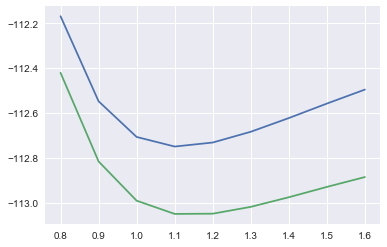

In [46]:
plt.plot(r, E_HF, label="HF")
plt.plot(r, E_CCSDT, label="CCSDT")